In [2]:
import torch
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
import torch.nn.functional as F
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D
from collections import deque


import plotly.graph_objects as go
import plotly.express as px


%load_ext autoreload
%autoreload 2
from help_functions.make_conv_2d_torch import make_conv_2d_torch
from help_functions.make_conv_3d_torch import make_conv_3d_torch
from help_functions.morph_fill import morph_fill
from help_functions.Sub_AT_torch import Sub_AT_torch
from help_functions.Sub_A_torch import Sub_A_torch
from help_functions.solve_least_squares_subdivision import solve_least_squares_subdivision
from help_functions.plot_subdivision_points import plot_subdivision_points
from help_functions.solve_least_squares_subdivision import apply_C

from help_functions.make_html_visual import make_html_visual
from help_functions.make_scatter_visual import make_scatter_visual

from IPython.display import HTML



In [3]:
'''
Здесь импортируем изображение, центрируем и поворачиваем при надобности
'''

raw_data = np.loadtxt('./models/BuddaAll.txt').reshape(-1)
int_cast_data = np.trunc(raw_data*np.power(10,3)).astype(int).reshape(-1, 3)


shifted = (int_cast_data - int_cast_data.min(axis=0) + np.array([10,10,10]))
sizes = (int_cast_data.max(axis=0) - int_cast_data.min(axis=0) + np.array([20,20, 20])).astype(int)
budda_tensor_3D = torch.zeros(tuple(sizes), dtype=int)

budda_tensor_3D[shifted[:, 0], shifted[:, 1], shifted[:, 2]] = 1

budda_tensor_3D_rotated_90 = torch.rot90(input = budda_tensor_3D, k=1, dims=(1, 2))

make_scatter_visual(budda_tensor_3D_rotated_90, 'budda_input_data')
make_html_visual(tensor_3d=budda_tensor_3D, name='budda-raw', colorscale='Jet')

# budda_tensor_3D = budda_tensor_3D_rotated_90


Всего точек: 64312
Размер тензора: torch.Size([101, 101, 218])
Плотность: 0.028920
Файл сохранен в ./htmls/budda-raw.html


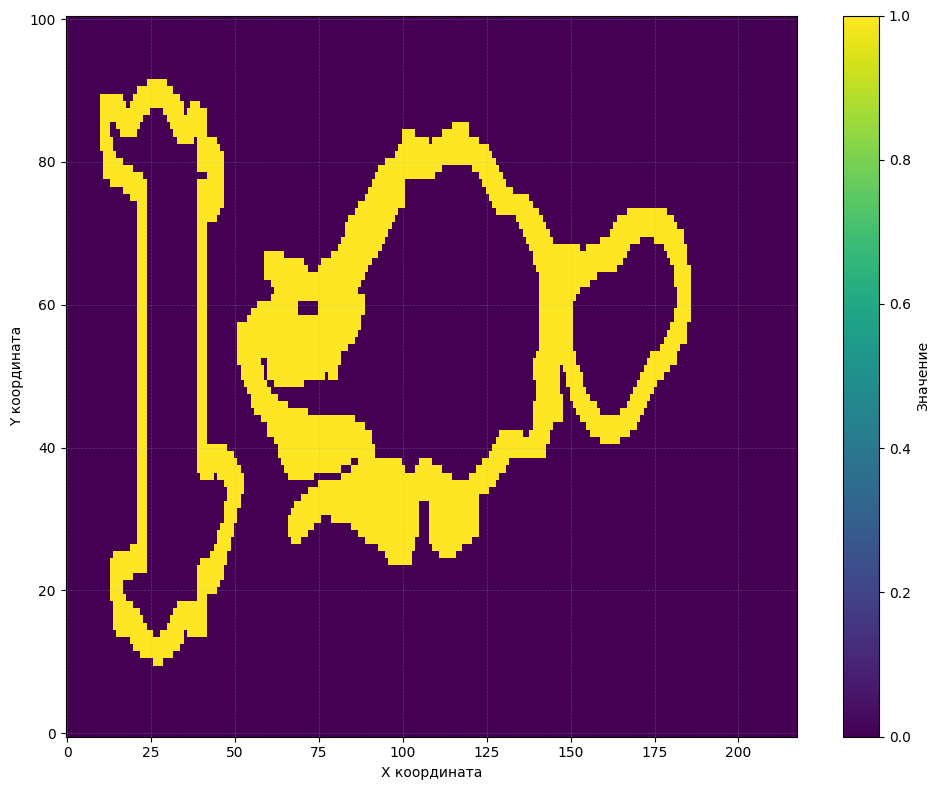

In [4]:
'''
Здесь утолщаем границы
'''

# budda_tensor_3D_slice = budda_tensor_3D[:,:, 30]

# kernel_2D = torch.ones(size=(3,3))
kernel_3D = torch.ones(size=(3,3,3))


# budda_conv_result_2D = make_conv_2d_torch(source=budda_tensor_3D_slice, kernel=kernel_2D)
budda_conv_result_3D = make_conv_3d_torch(source=budda_tensor_3D, kernel=kernel_3D)




plt.figure(figsize=(10, 8))
    
plt.imshow(budda_conv_result_3D[:,:, 60], 
           cmap='viridis', 
           aspect='auto',
           origin='lower')  

plt.colorbar(label='Значение')
plt.xlabel('X координата')
plt.ylabel('Y координата')

plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig('./images/budda-2d-slice-after-conv.png')
plt.show()



In [5]:
make_html_visual(budda_conv_result_3D, 'budda_conv_result_3D_3')
# HTML(filename='./htmls/voxel_model_budda_5_rare.html')

Файл сохранен в ./htmls/budda_conv_result_3D_3.html


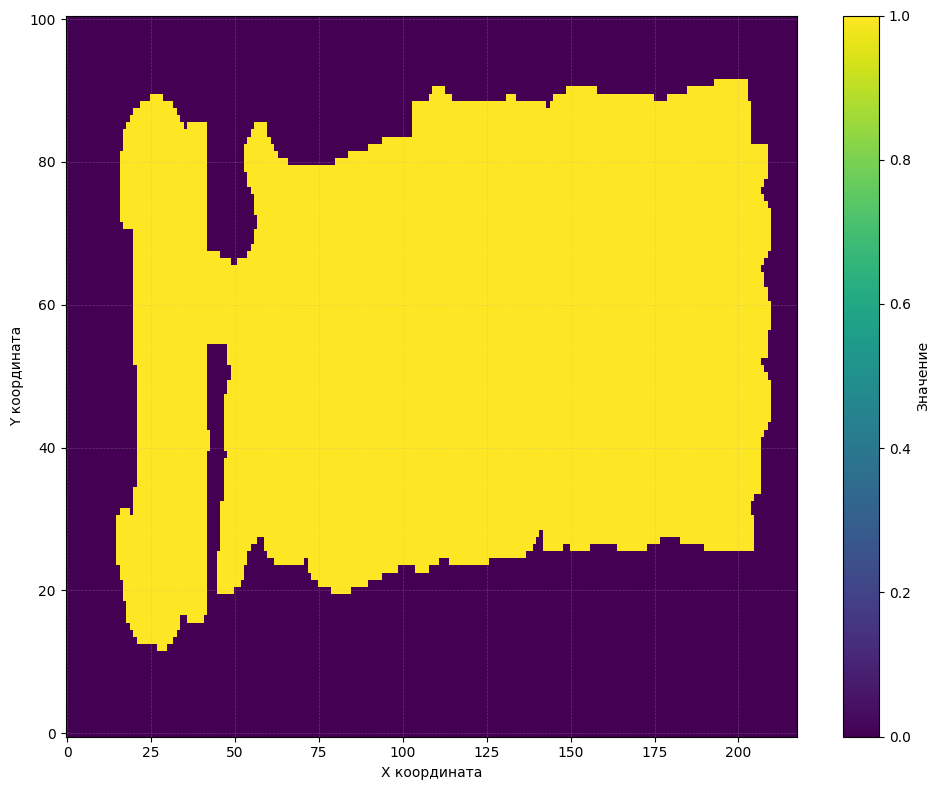

In [6]:
'''
Морфологическое заполнение
'''


budda_conv_result_2D_filled = morph_fill(budda_conv_result_3D[:,:, 34])

plt.figure(figsize=(10, 8))
    
plt.imshow(budda_conv_result_2D_filled, 
           cmap='viridis', 
           aspect='auto',
           origin='lower')  

plt.colorbar(label='Значение')
plt.xlabel('X координата')
plt.ylabel('Y координата')

plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig('./images/turbine_slice_conv_filled.png')
plt.show()

In [7]:
budda_conv_result_3D_filled = morph_fill(budda_conv_result_3D)

In [8]:
mask = torch.tensor([0, 1, 3, 3, 1], dtype=torch.float32) / 4

# Z - характористическая функция поверхности
Z = budda_conv_result_3D_filled


x0 = solve_least_squares_subdivision(Z, mask)
z_rec = Sub_A_torch(mask, x0)

# error = torch.norm(z_rec - Z)
# print(error)

Shape of r torch.Size([51, 109, 51])
ITER: 0, grad norm = 144.5602569580078
ITER: 1, grad norm = 65.444091796875
ITER: 2, grad norm = 39.21061706542969
ITER: 3, grad norm = 27.701229095458984
ITER: 4, grad norm = 20.03322982788086
ITER: 5, grad norm = 15.89518928527832
ITER: 6, grad norm = 12.454988479614258
ITER: 7, grad norm = 10.484187126159668
ITER: 8, grad norm = 8.578113555908203
ITER: 9, grad norm = 7.470620632171631
ITER: 10, grad norm = 6.276184558868408
ITER: 11, grad norm = 5.58837890625
ITER: 12, grad norm = 4.781069278717041
ITER: 13, grad norm = 4.325662612915039
ITER: 14, grad norm = 3.751462697982788
ITER: 15, grad norm = 3.4361634254455566
ITER: 16, grad norm = 3.012157678604126
ITER: 17, grad norm = 2.7864060401916504
ITER: 18, grad norm = 2.46401047706604
ITER: 19, grad norm = 2.2979719638824463
ITER: 20, grad norm = 2.046898603439331
ITER: 21, grad norm = 1.9220359325408936
ITER: 22, grad norm = 1.7225375175476074
ITER: 23, grad norm = 1.6268131732940674
ITER: 24, g

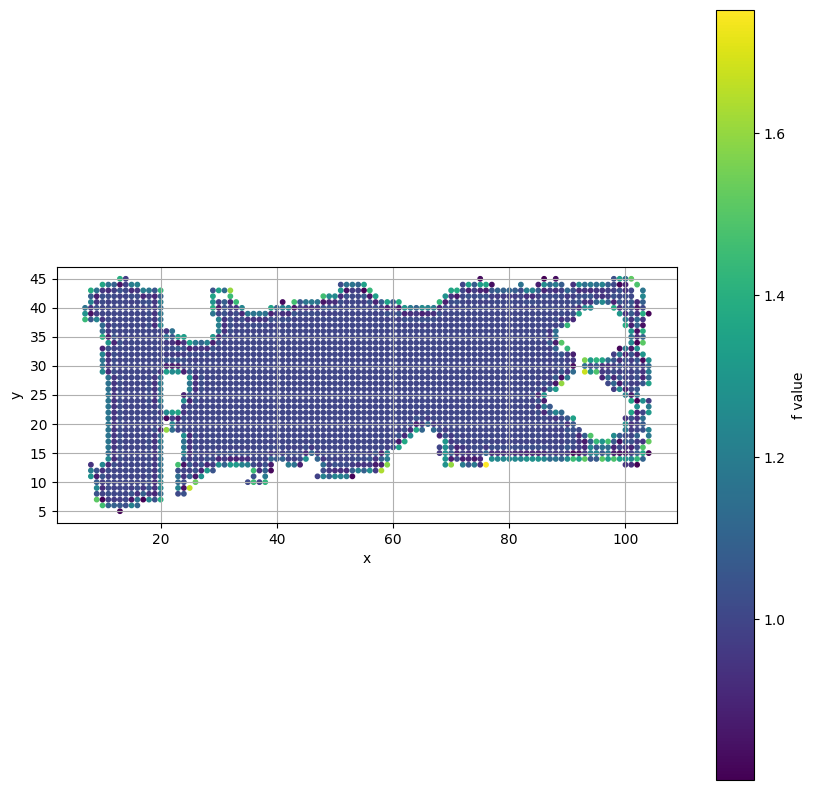

In [17]:
plot_subdivision_points(x0[:,:,20], threshold=0.8, do_ceil=False)

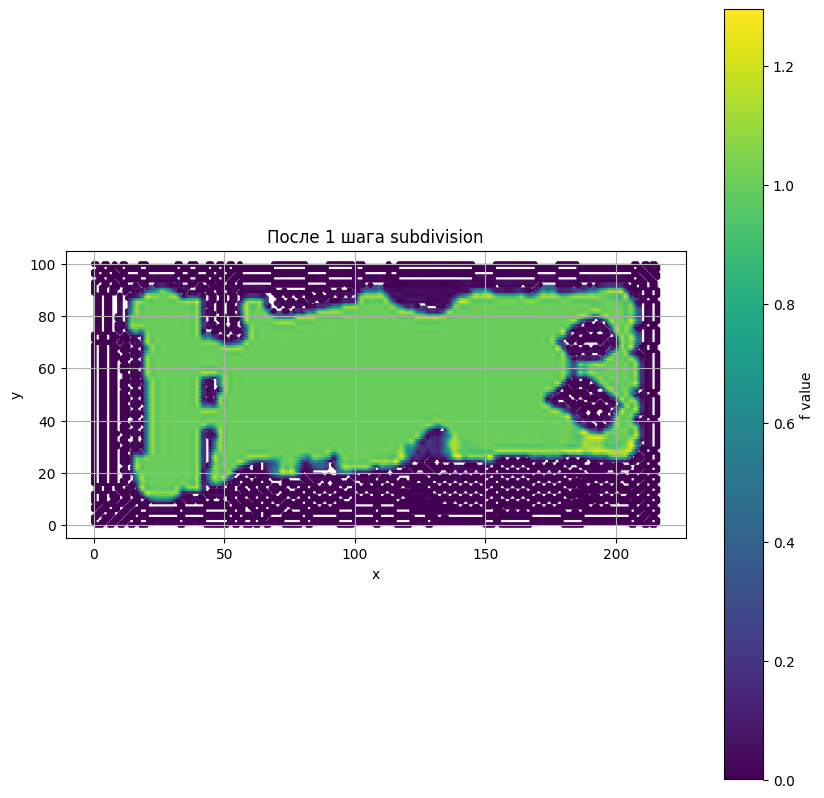

4


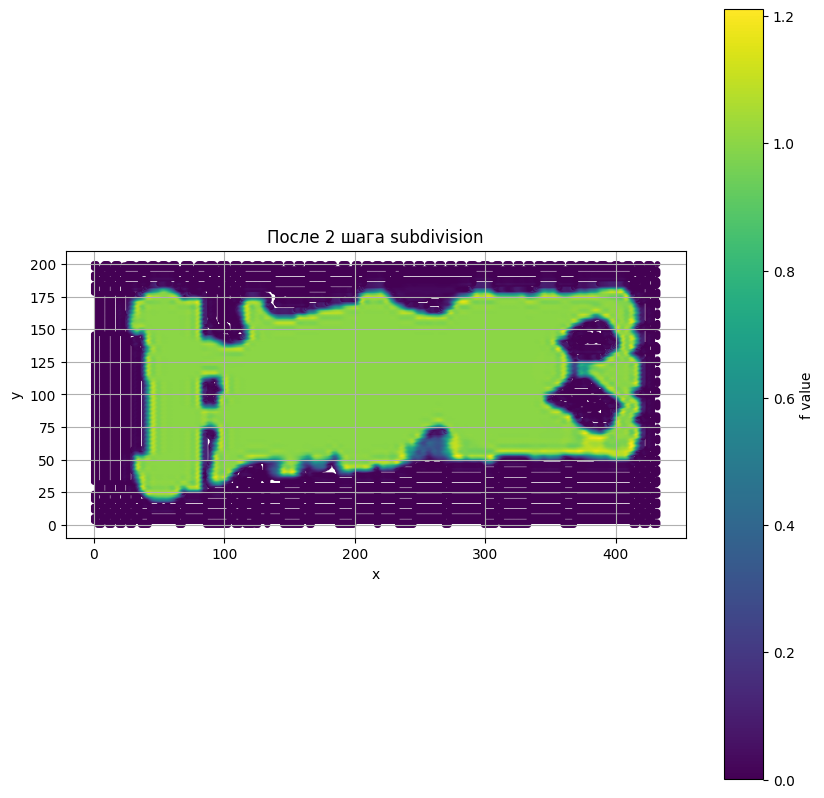

8


In [40]:
x0_clone = x0.clone()
k = 2
for i in range(3):
    x0_clone = Sub_A_torch(mask, x0_clone)
    plot_subdivision_points(
        x0_clone[:,:,20*k],
        threshold=0.00,
        title=f"После {i+1} шага subdivision",
        figsize=(10,10),
        do_ceil= False,
        visual_type= 'scatter'
    )
    k *=2
    print(k)

In [30]:
# x0_clone = Sub_A_torch(mask, x0_clone)

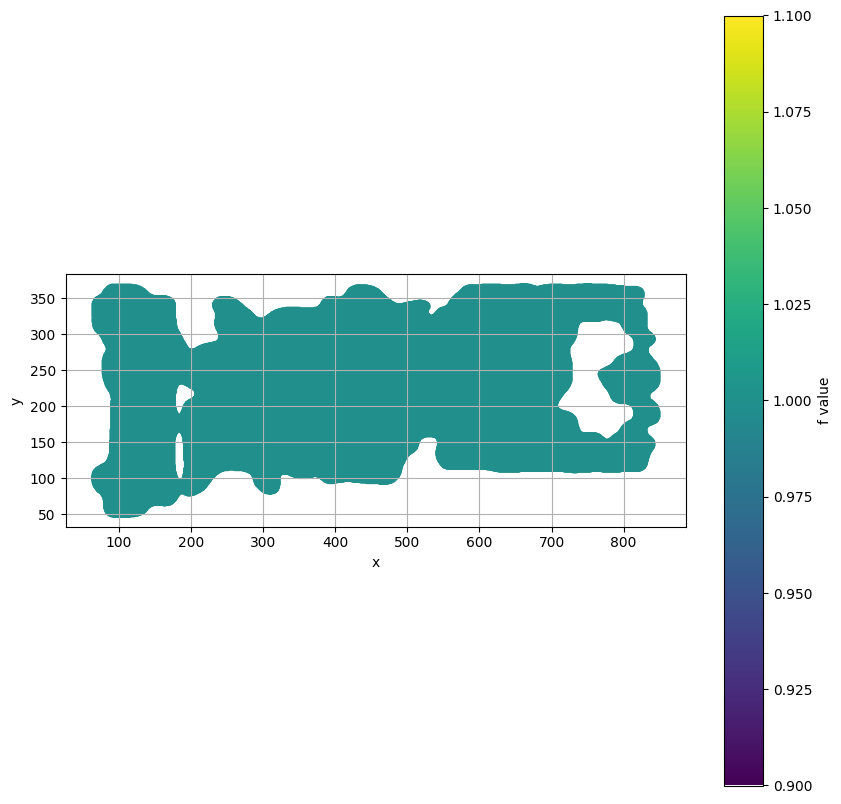

In [23]:
threshold = 0.6
# x0_clone_filtered = torch.where(x0_clone > threshold, x0_clone, torch.tensor(0.0))

x0_clone_filtered_ceil = (x0_clone > threshold).float()
plot_subdivision_points(data = x0_clone_filtered_ceil[:,:,10*16],
                        threshold=0.90,
                        title='',
                        figsize=(10,10),
                        do_ceil=False,
                        visual_type='scatter')

In [193]:
x0_clone_filtered_ceil[:,:,20*8]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [10]:
import torch
import numpy as np
from skimage import measure
import pyvista as pv
pv.start_xvfb()


def volume_to_mesh(volume: torch.Tensor, level=0.5):
    volume_np = volume.detach().cpu().numpy().astype(np.float32)

    verts, faces, normals, values = measure.marching_cubes(
        volume_np,
        level=level
    )

    return verts, faces, normals

/home/alexander/DIPLOM/.diplom3d/lib/python3.8/site-packages/pyvista/jupyter/notebook.py:37: UserWarning:

Failed to use notebook backend: 

No module named 'trame'

Falling back to a static output.



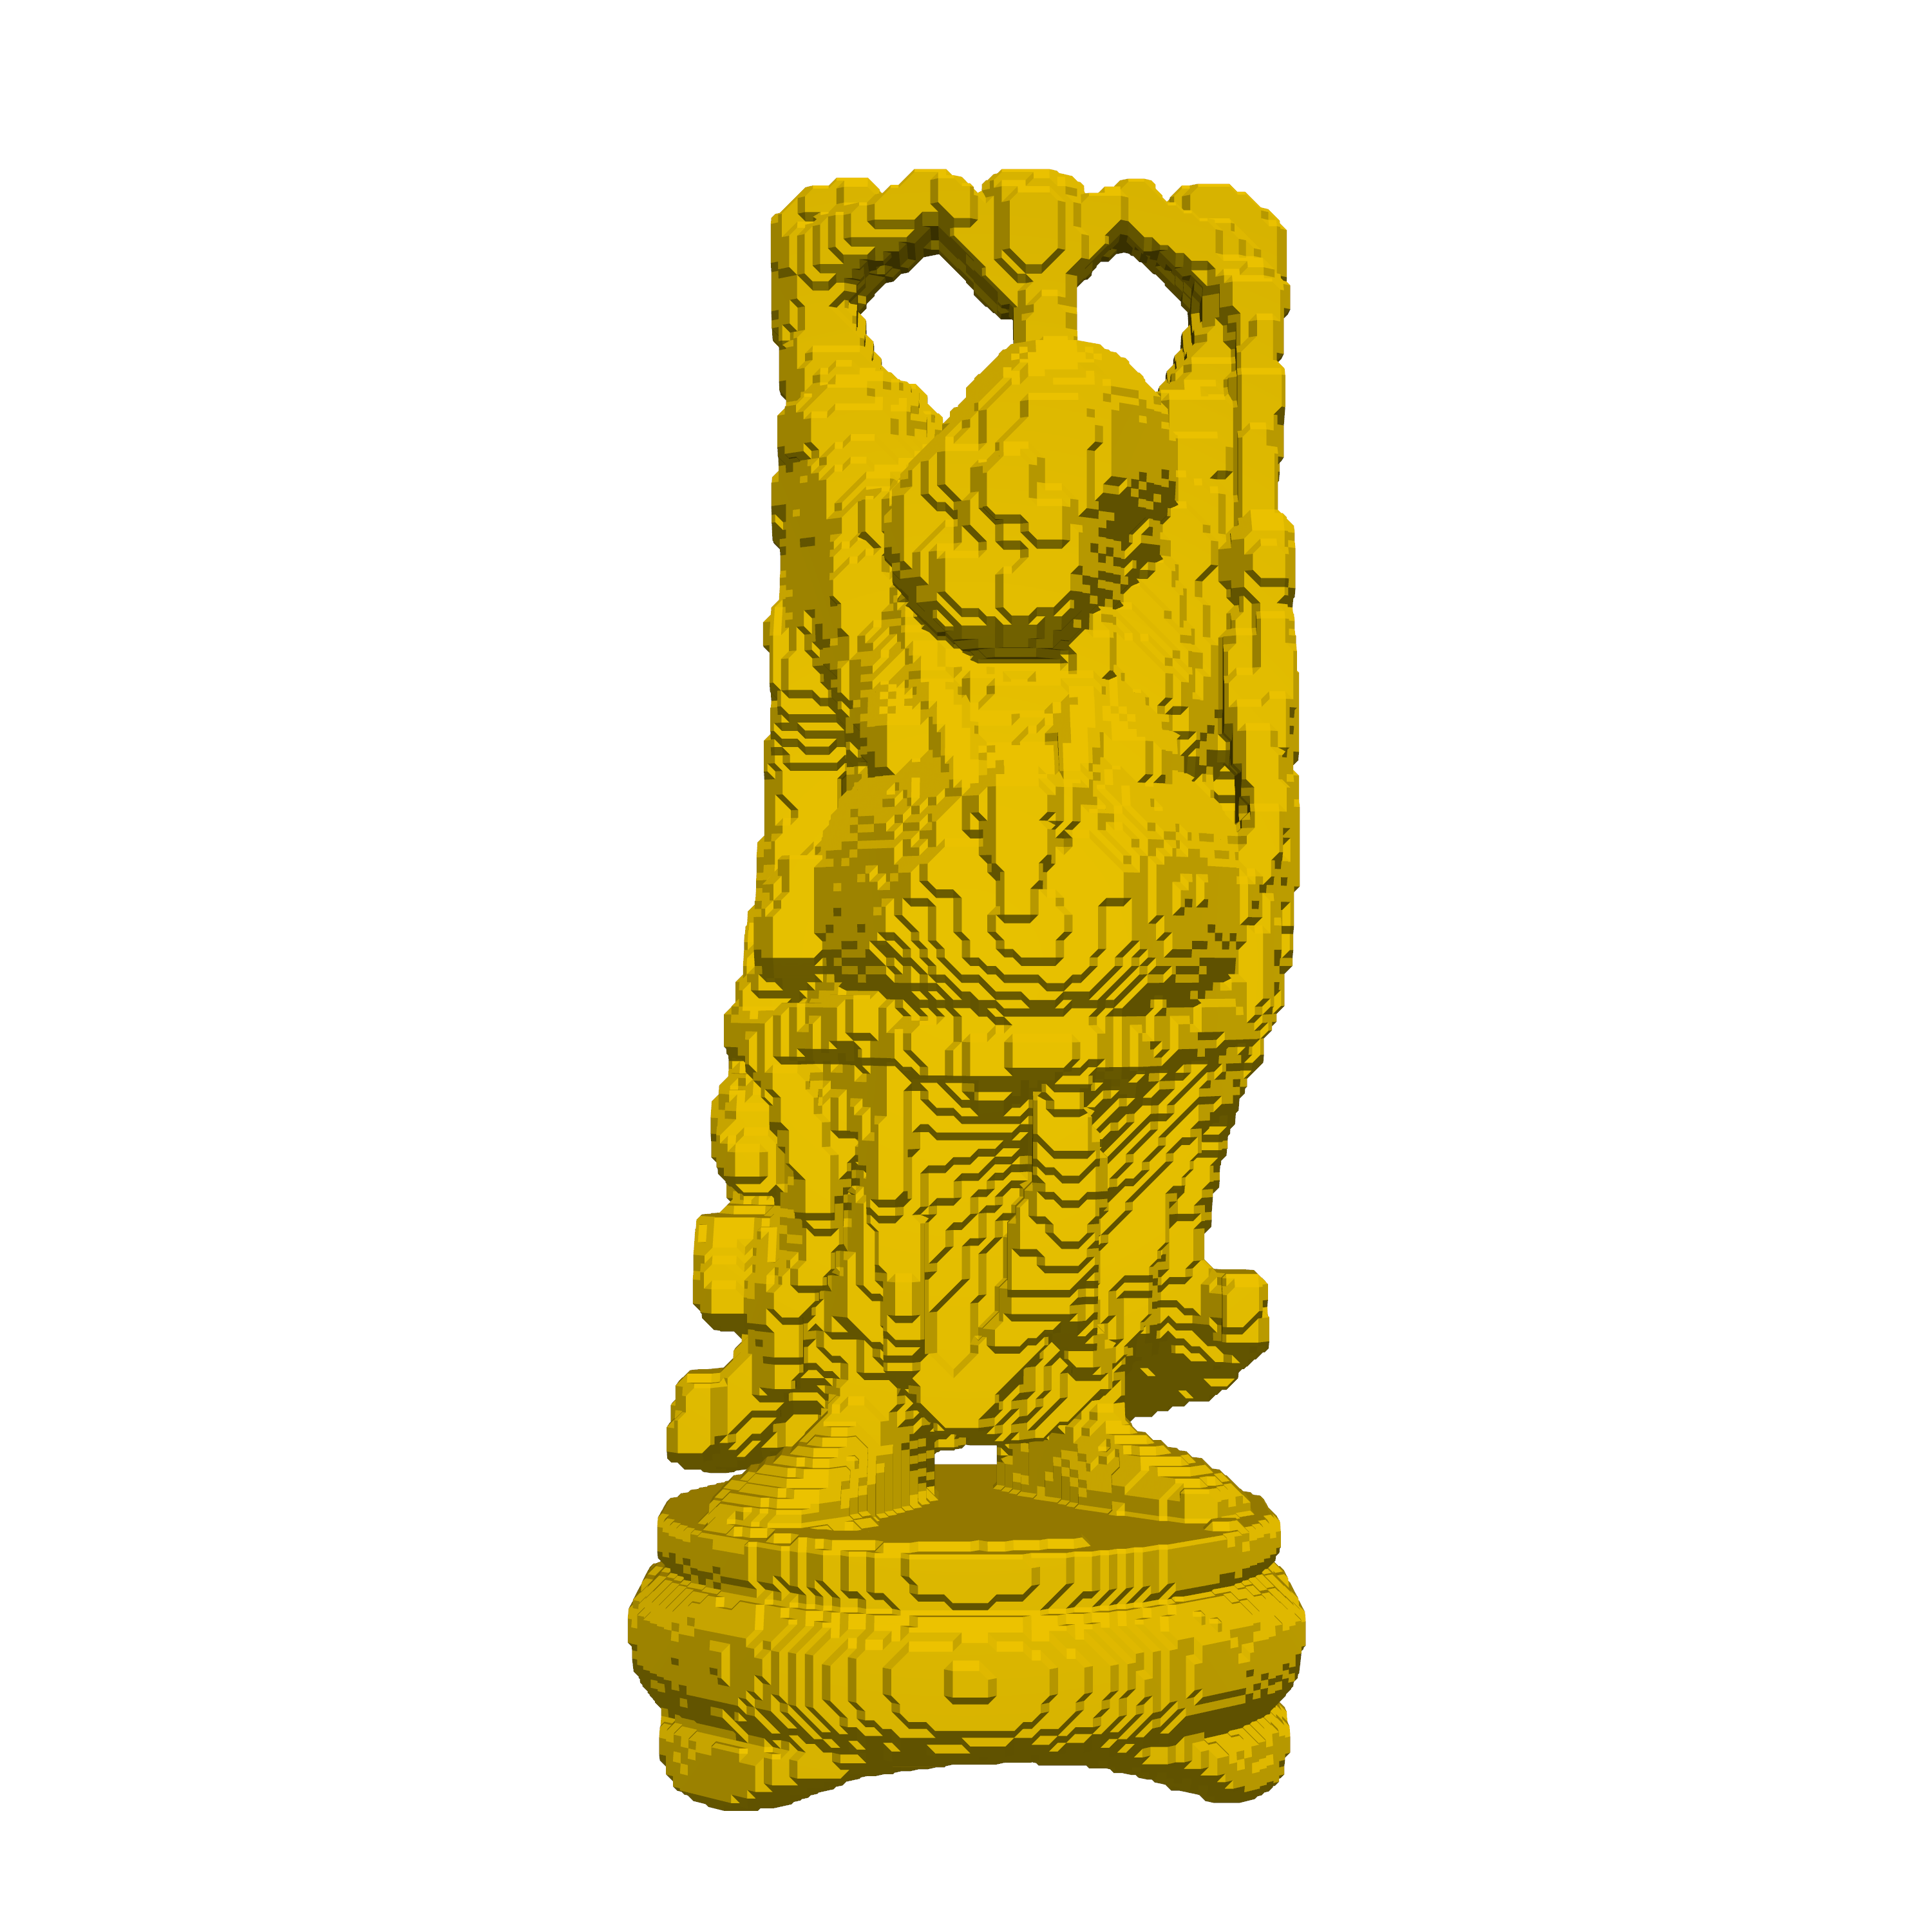

In [39]:
x0_clone = x0.clone()
threshold = 0.8

x0_clone = (x0_clone > threshold).float()

surface = Z

surface_rot = torch.rot90(surface, k=1, dims=(1,2))
surface_rot = torch.rot90(surface_rot, k=2, dims=(0,1))
surface_rot = torch.rot90(surface_rot, k=-1, dims=(0,1))


verts, faces, normals = volume_to_mesh(surface_rot)

faces_pv = np.hstack(
    [np.full((faces.shape[0], 1), 3), faces]
).astype(np.int64)

mesh = pv.PolyData(verts, faces_pv)
mesh.point_data["Normals"] = normals

plotter = pv.Plotter(off_screen=True,
                     window_size=(3000, 3000))
plotter.add_mesh(
    mesh,
    color="gold",
    smooth_shading=False,
    specular=0.5,
    specular_power=30
)
plotter.view_yz()



plotter.show(screenshot="figure_x0.png",
             window_size=(3000, 3000))

# plotter.save_graphic
